--- Fetching Optical Data ---


Retrieving AbsorptionDoc documents: 100%|██████| 1/1 [00:00<00:00, 17549.39it/s]


[SUCCESS] Found data for Si (mp-149)

--- Results for Si ---
rbf        | MSE: 8590191558.4639 | R2: 0.9847
linear     | MSE: 173702200933.4313 | R2: 0.6911
poly       | MSE: 341521698508.7417 | R2: 0.3926
sigmoid    | MSE: 1093522375208406400.0000 | R2: -1944901.9282


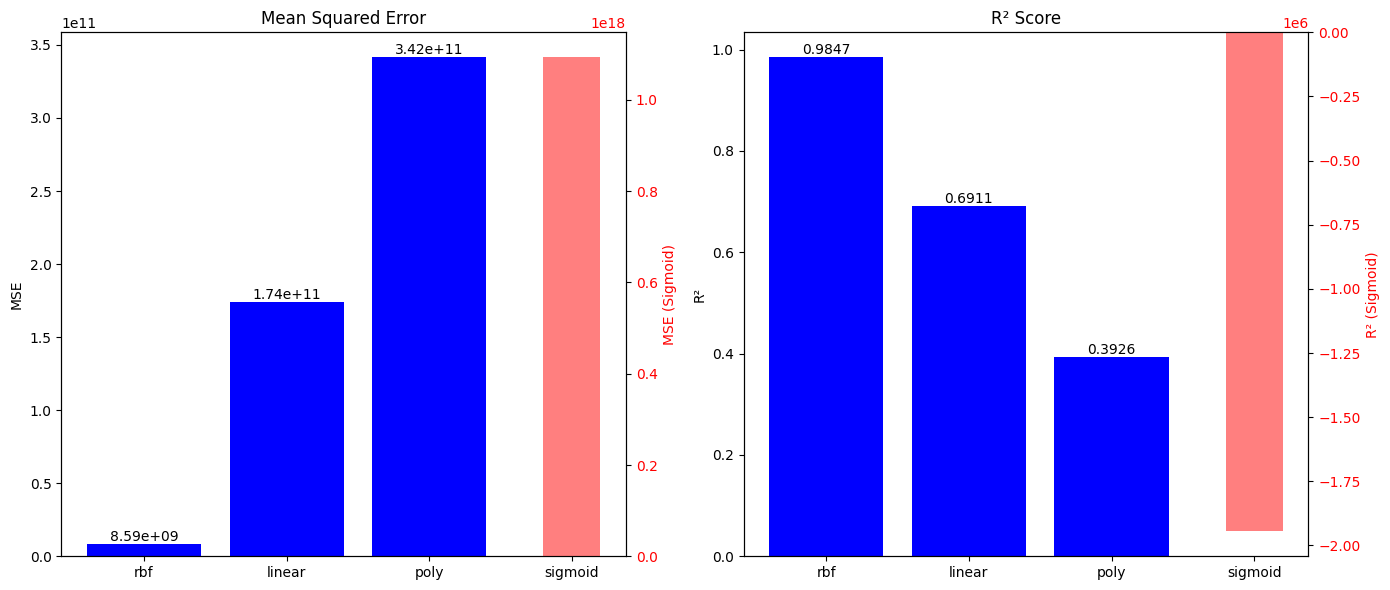

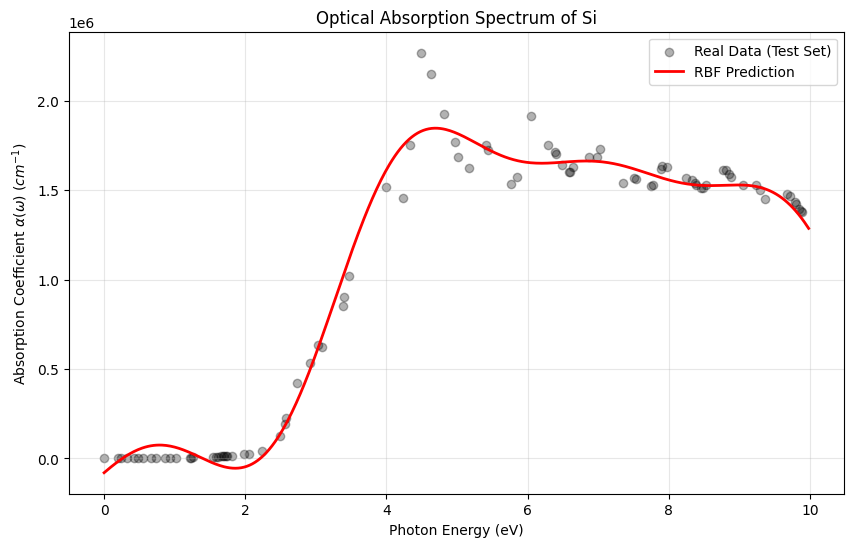

In [8]:
# -----------------------------------------------------------------------------
# Copyright (c) 2025 Renata Wong
#
# This code is supplementary material for the research paper:
# "Support Vector Machine Kernels as Quantum Propagators"
#
# Licensed under the MIT License.
# You may obtain a copy of the License at: https://opensource.org/licenses/MIT
# -----------------------------------------------------------------------------


import numpy as np
import pandas as pd
from mp_api.client import MPRester
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------
API_KEY = "YOUR-API-KEY" 
CANDIDATE_IDS = ["mp-149", "mp-2534", "mp-804"] # Silicon, GaAs, GaN

# -----------------------------------------------------------------------------
# 1. FETCH OPTICAL DATA
# -----------------------------------------------------------------------------
energies = []
absorption = []
formula_used = None
material_id_used = None

print("--- Fetching Optical Data ---")
with MPRester(API_KEY) as mpr:
    for mid in CANDIDATE_IDS:
        try:
            docs = mpr.materials.absorption.search(material_ids=[mid])
            if docs:
                doc = docs[0]
                # Try standard attribute locations
                if hasattr(doc, "spectrum"):
                    spec = doc.spectrum
                    if hasattr(spec, "get"): # dict
                        energies = np.array(spec.get("energy"))
                        absorption = np.array(spec.get("absorption_coefficient"))
                    else: # object
                        energies = np.array(spec.energy)
                        absorption = np.array(spec.absorption_coefficient)
                elif hasattr(doc, "energies"):
                     energies = np.array(doc.energies)
                     absorption = np.array(doc.absorption_coefficient)
                
                if len(energies) > 0:
                    material_id_used = mid
                    formula_used = doc.formula_pretty if hasattr(doc, "formula_pretty") else mid
                    print(f"[SUCCESS] Found data for {formula_used} ({mid})")
                    break
        except Exception:
            continue

# Fallback
if len(energies) == 0:
    print("[WARNING] Using synthetic data.")
    energies = np.linspace(0, 10, 200)
    absorption = 5000 * np.exp(-(energies - 4.0)**2 / 0.5) 
    formula_used = "Synthetic"

# -----------------------------------------------------------------------------
# 2. PREPARE DATA
# -----------------------------------------------------------------------------
mask = (energies < 10) # 0-10 eV range
X = energies[mask].reshape(-1, 1)
y = absorption[mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# -----------------------------------------------------------------------------
# 3. TRAIN & EVALUATE
# -----------------------------------------------------------------------------
kernels = ['rbf', 'linear', 'poly', 'sigmoid']
results = {}

print(f"\n--- Results for {formula_used} ---")
for k in kernels:
    model = SVR(kernel=k, C=100, gamma='scale')
    if k == 'poly': model.degree = 3
    
    model.fit(X_train_scaled, y_train_scaled)
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[k] = {'MSE': mse, 'R2': r2}
    print(f"{k:<10} | MSE: {mse:.4f} | R2: {r2:.4f}")

# -----------------------------------------------------------------------------
# 4. PLOT BAR GRAPHS (MSE & R2)
# -----------------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

names = [k for k in kernels if k != 'sigmoid']
mse_vals = [results[k]['MSE'] for k in names]
r2_vals = [results[k]['R2'] for k in names]
colors = ['blue' if 'custom' not in k else 'purple' for k in names]

# MSE
bars1 = ax1.bar(names, mse_vals, color=colors)
ax1.set_title("Mean Squared Error")
ax1.set_ylabel("MSE")
for bar in bars1:
    val = bar.get_height()
    va = 'bottom' if val >= 0 else 'top'
    y_pos = val if val >= 0 else val - 0.05
    ax1.text(bar.get_x() + bar.get_width()/2, y_pos, f"{val:.2e}", ha='center', va='bottom')
    #ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{bar.get_height():.4f}", ha='center', va='bottom')

# Sigmoid MSE (Twin)
if 'sigmoid' in results:
    ax1t = ax1.twinx()
    ax1t.bar(['sigmoid'], [results['sigmoid']['MSE']], color='red', width=0.4, alpha=0.5)
    ax1t.set_ylabel("MSE (Sigmoid)", color='red')
    ax1t.tick_params(axis='y', labelcolor='red')

# R2
bars2 = ax2.bar(names, r2_vals, color=colors)
ax2.set_title("R² Score")
ax2.set_ylabel("R²")
for bar in bars2:
    val = bar.get_height()
    va = 'bottom' if val >= 0 else 'top'
    y_pos = val if val >= 0 else val - 0.05
    ax2.text(bar.get_x() + bar.get_width()/2, y_pos, f"{val:.4f}", ha='center', va='bottom')

# Sigmoid R2 (Twin)
if 'sigmoid' in results:
    ax2t = ax2.twinx()
    ax2t.bar(['sigmoid'], [results['sigmoid']['R2']], color='red', width=0.4, alpha=0.5)
    ax2t.set_ylabel("R² (Sigmoid)", color='red')
    ax2t.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.savefig("optical_metrics_comparison.png")
plt.show()










# HERE

# -----------------------------------------------------------------------------
# 5. PLOT PREDICTION CURVE
# -----------------------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='black', alpha=0.3, label='Real Data (Test Set)')

# RBF Prediction
model_rbf = SVR(kernel='rbf', C=100, gamma='scale')
model_rbf.fit(X_train_scaled, y_train_scaled)
X_grid = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
y_grid = scaler_y.inverse_transform(model_rbf.predict(scaler_X.transform(X_grid)).reshape(-1, 1))

plt.plot(X_grid, y_grid, color='red', linewidth=2, label='RBF Prediction')
plt.title(f"Optical Absorption Spectrum of {formula_used}")
plt.xlabel("Photon Energy (eV)")
plt.ylabel(r"Absorption Coefficient $\alpha(\omega)$ ($cm^{-1}$)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("optical_spectrum_curve.png")
plt.show()